# P5 - Vehicle Detection - Model Execution on images

# File sections:
* import section
* general utilities
* load the training data and data exporation
* HOG parameters selection by visualization
* Spacial parameters selection by visualization
* Color Hist parmeters selection

## imports for the whole project

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
import matplotlib.image as mpimg
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from random import randint
import time
from sklearn.svm import LinearSVC
from IPython import display


%matplotlib inline

### imports for the whole project - end

## General Utility Functions - not directed related to the project

In [2]:
# Read Image
def readImages(dir, pattern = '*[.png][.jpg][.jepg]', cFormat='RGB'):
    # read all images with the given patterns (extensions) in the sub-directories
    # Example of a pattern: pattern = '*[.png][.jpg]'

    """
    Returns an image list with the image contained on the directory `dir` matching the `pattern`.
    pattern
    """
    images = []
    for imageFileName in glob.iglob(dir + '**/' + pattern, recursive=True):
        images.append(mpimg.imread(imageFileName))
    return images


def display_save_images_single_line(images, folder, titles, figTitel='', figsize=(6, 3), gray=False):
    plt.figure(figsize=figsize)
    for i in range (len(images)):
        plt.subplot(1, len(titles), i+1)
        plt.title(titles[i])
#        plt.axis('off')
        if gray == True:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i]) # , cmap='binary'
        plt.tight_layout(pad=0.50)
    plt.tight_layout(pad=0.50)
#    plt.xlabel(figTitel) #, fontdict=font)
    plt.suptitle(figTitel, fontsize=16)
    plt.subplots_adjust(left=0, wspace=0, top=0.8)
    if not os.path.exists(folder): #if output dir doesn't exists, create it
        os.makedirs(folder)
        plt.savefig(os.path.join(folder, figTitel))
    plt.show()

### General Utility Functions - end

## Parameters definition - classes

# Value object to hold all feature extraction parameters.

In [3]:
class HogParameters():
    def __init__(self):
        # HOG parameters
        self.orient = 9
        self.pix_per_cell = 8
        self.cell_per_block = 2
        self.vis= False

class FeaturesParameters():
    def __init__(self):
        # consider different channels from differnet colors
        self.combined_channels = [['YCrCb',[0,1,2]]] #,['HLS',[0]]] # [['RGB',[0]], ['YCrCb',[0,2]],['HSV',[0]],['LUV',[0,1]]] # 6 channels! instead of 3'RGB' #'YCrCb' [['YCrCb',[0,1,2]]] #
        self.color_space = 'YCrCb' #[('RGB',0),('YCrCb',1),('HSV',0),('LUV',1),('LUV',1)] #'RGB' #'YCrCb'
        # Bin spatial parameters
        self.spatial_size = (32, 32)
        # Histogram parameters
        self.hist_bins = 32
        self.hist_range = (0, 255)
        # HOG parameters
        self.hog_params=HogParameters()
        
        
class DetectionParameters():
    def __init__(self):
        self.ystart = 400
        self.ystop = 656
        self.scale = 1.5

### Parameters definition - end

# 3. Pipeline

## Features extraction and Model fitting: 

### Extract Features: Individual features

In [4]:
# Define a function to return HOG features and visualization
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

def get_hog_channel_features(feature_image, p, vis, feature_vec):
    return (hog(feature_image, orientations=p.orient, pixels_per_cell=(p.pix_per_cell,p.pix_per_cell),
                cells_per_block=(p.cell_per_block, p.cell_per_block), 
                visualise=vis, transform_sqrt=True, feature_vector=feature_vec))

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    colors = cv2.resize(img[:,:,img.shape[2]-1], size).ravel()
    for channel in range(img.shape[2]-1):
        nextColor = cv2.resize(img[:,:,img.shape[2]-channel-2], size).ravel()
        colors = np.hstack((colors, nextColor))
    return colors

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    hists = np.histogram(img[:,:,img.shape[2]-1], bins=nbins)[0]
    for channel in range(img.shape[2]-1):
            nextHist = np.histogram(img[:,:,img.shape[2]-channel-2], bins=nbins)[0] # , range=bins_range
            hists = np.concatenate(([hists, nextHist]))
    return hists

### Extract Features: Main function

### load the test data (not part of the pipeline)

## Pipeline for using the model

In [5]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_channel_features(ch1, hog_params, vis = False, feature_vec=False)
    hog2 = get_hog_channel_features(ch2, hog_params, vis = False, feature_vec=False)
    hog3 = get_hog_channel_features(ch3, hog_params, vis = False, feature_vec=False)
    boxlist=[]
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    

            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)

            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)

                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxlist.append(((int(xbox_left),int(ytop_draw+ystart)),
                               (int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
    return draw_img, boxlist

### Load Model 

In [6]:
dist_pickle = pickle.load( open( "./model.p", "rb" ) )
svc = dist_pickle["svc"]; 
X_scaler = dist_pickle["X_scaler"]

In [ ]:
### Load test data and set parmaeters

In [ ]:
test_images = readImages('./test_images/', '*.jpg')
params = FeaturesParameters()
detec_params = DetectionParameters()

hog_params = params.hog_params
orient = params.hog_params.orient
pix_per_cell = params.hog_params.pix_per_cell
cell_per_block = params.hog_params.cell_per_block
spatial_size = params.spatial_size
hist_bins = params.hist_bins
combined_channels = params.combined_channels

In [ ]:
Test on images

/home/carkyo1080-1/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


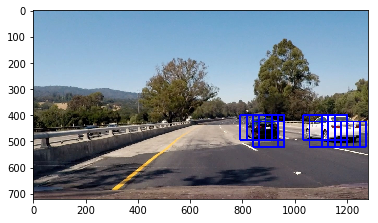

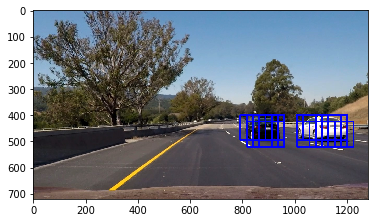

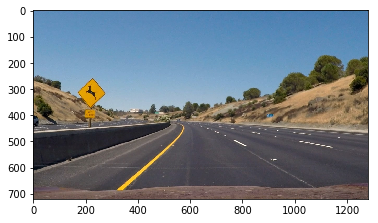

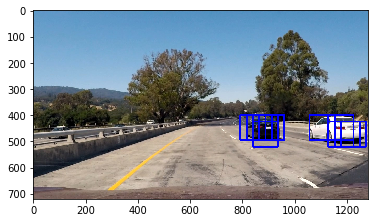

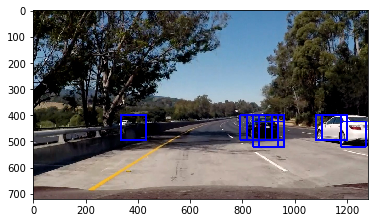

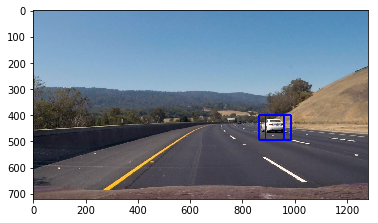

In [7]:
for image in test_images:
    out_img,boxlist = find_cars(image, DetectionParameters.ystart, DetectionParameters.ystop, DetectionParameters.scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    display.display(plt.gcf())
    plt.imshow(out_img)